<a href="https://colab.research.google.com/github/Rasangasandeepa/MIT--Research-Retail-AI/blob/main/CAPSTONE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries and Loading Data

In [ ]:
# Install the lifetimes package for customer lifetime value analysis
!pip install lifetimes

# Import necessary libraries
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For data visualization
from statsmodels.tsa.arima.model import ARIMA  # For time series analysis using ARIMA model
import seaborn as sns  # For statistical data visualization
import missingno as msno  # For visualizing missing data patterns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive # Import the drive module from google.colab
drive.mount('/content/drive') # Mount your Google Drive to the Colab environment at the specified path

Mounted at /content/drive


In [ ]:
# Load the dataset into a Pandas DataFrame
df = pd.read_csv("/content/drive/MyDrive/DATASET.csv", delimiter=',', encoding="ISO-8859-1")

# Observing Datatypes, Columns and Rows

In [ ]:
# Display the first 5 rows of the DataFrame 'df'
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [ ]:
df.info() # Display information about the DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
df.describe() # Display descriptive statistics of the DataFrame

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# Data Cleaning: Checking for Null Values

<Axes: >

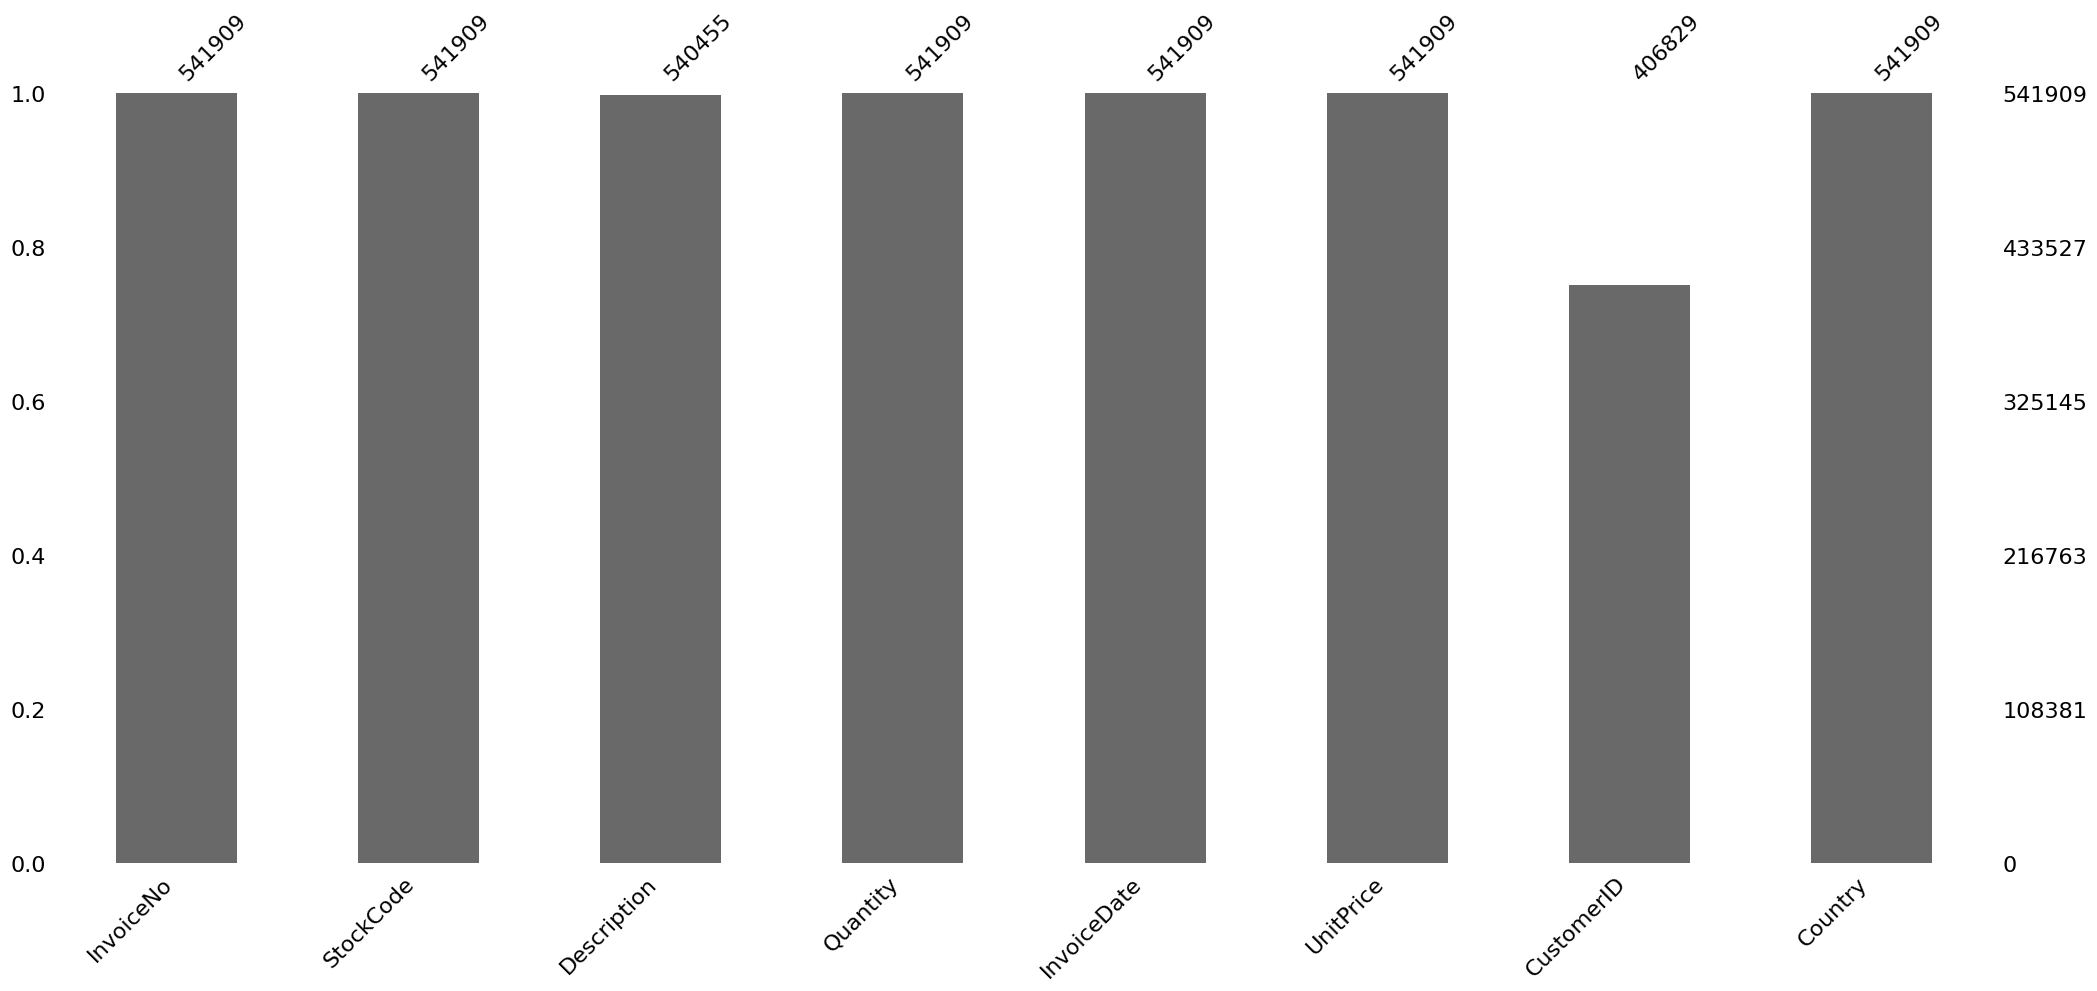

In [ ]:
msno.bar(df) # Check for missing values using a bar chart

* We observed that CustomerID is missing.
* We will first check approximately how many rows are mssing this detail
* Then we will delete the missing rows.
* The type of analysis I will be performing requires groupby according to customers so that is why it is necessary to remove null values from this column.

In [ ]:
df.count() # Count the number of non-null values in each column

,0
InvoiceNo,541909
StockCode,541909
Description,540455
Quantity,541909
InvoiceDate,541909
UnitPrice,541909
CustomerID,406829
Country,541909


In [ ]:
df[df['CustomerID'].isnull()].count() # Count the number of null values in the 'CustomerID' column

,0
InvoiceNo,135080
StockCode,135080
Description,133626
Quantity,135080
InvoiceDate,135080
UnitPrice,135080
CustomerID,0
Country,135080


In [ ]:
100 - ((541909-135000)/541909 * 100) # Calculate the percentage of missing data in the 'CustomerID' column

24.911931708091203

* Approximately 25% of the data is missing.
* We will prooceed with dropping the missing rows now.

In [ ]:
df.dropna(inplace=True) # Drop rows with missing values in the 'CustomerID' column

<Axes: >

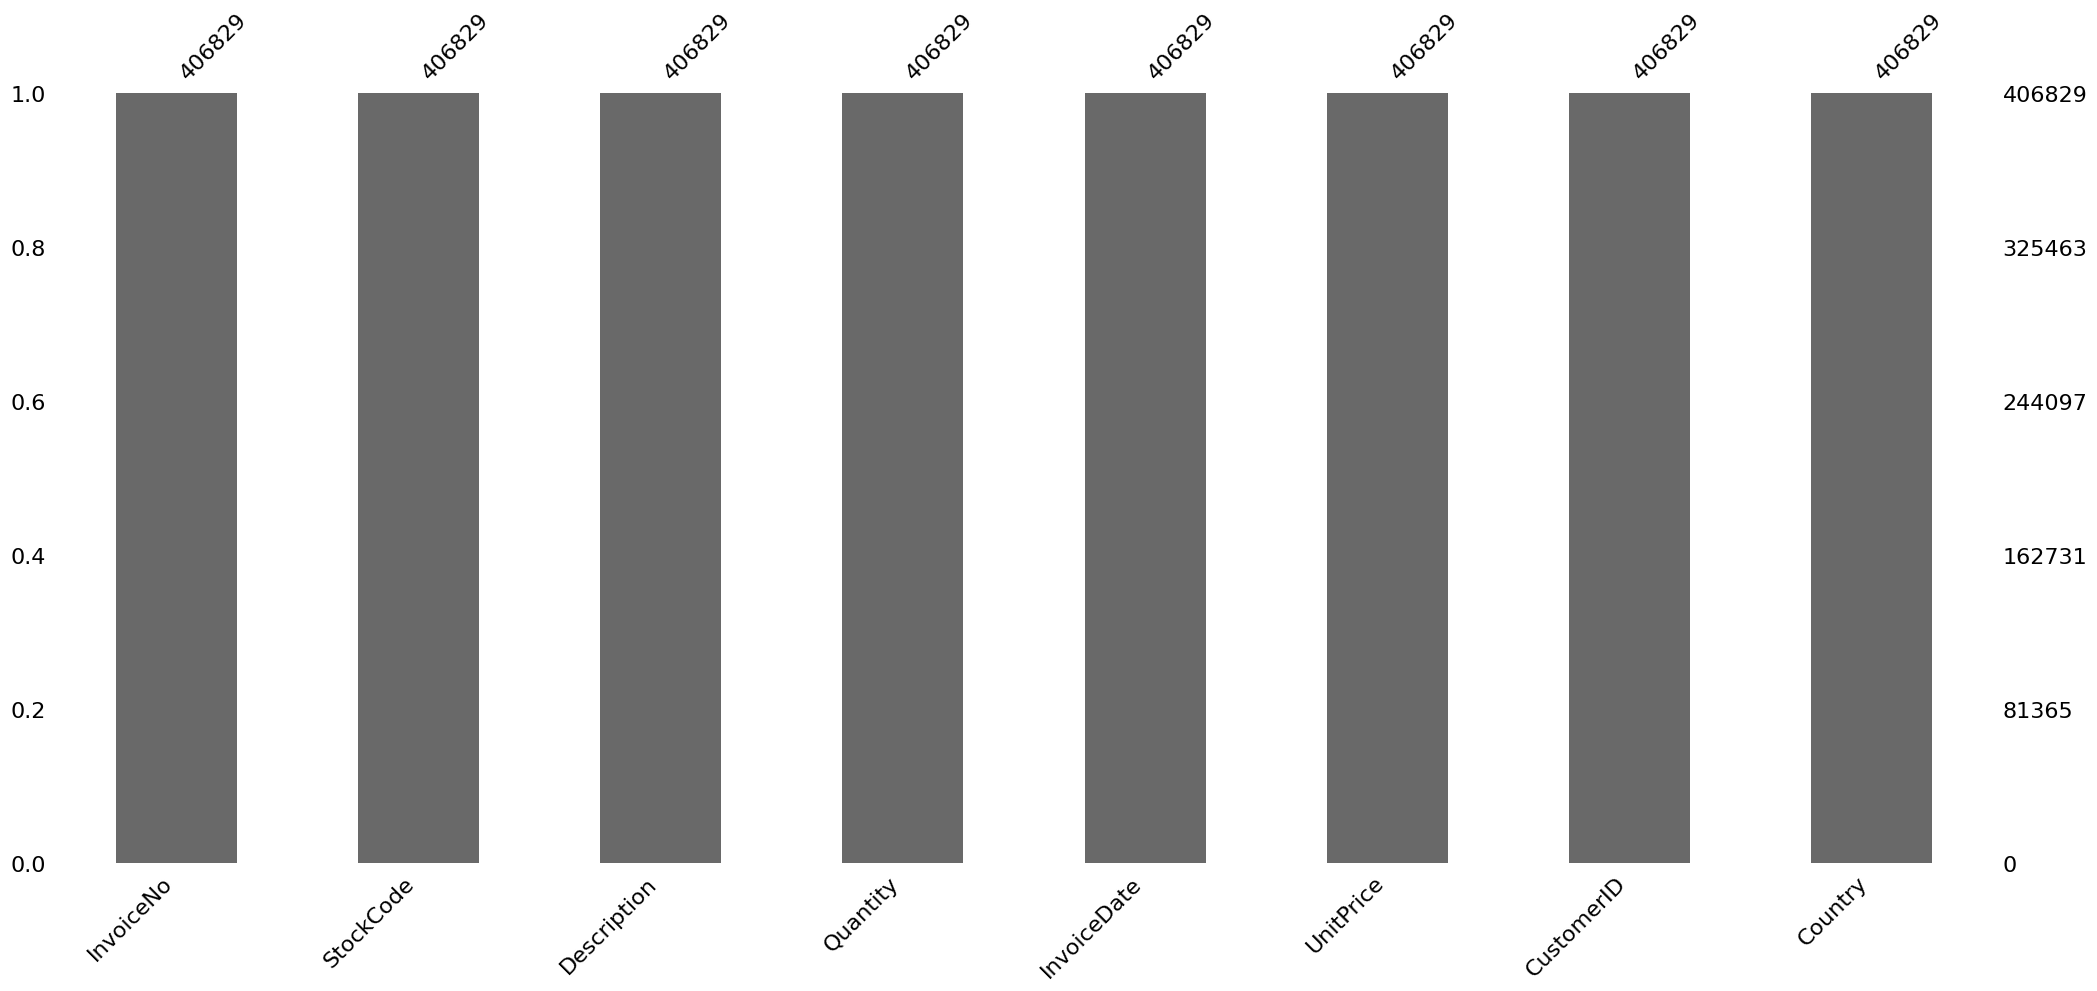

In [ ]:
msno.bar(df) # Recheck for missing values after dropping rows

* Now we can see above that the matrix is showing all bars are equal
* meaning that the data is clean and ready to be used in the model
* meanwhile we will change the data type of InvoiceDate to Datetime.
* We will also create three new fields:

1. Amount
2. Number of Transactons
3. Last Transactions(how many days ago was that customer's last transaction)

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M') # Convert 'InvoiceDate' column to datetime format

# Amount

In [ ]:
# Calculate total amount spent by each customer
df['Total Amount Spent']= df['Quantity'] * df['UnitPrice']

total_amount = df['Total Amount Spent'].groupby(df['CustomerID']).sum()
total_amount = pd.DataFrame(total_amount).reset_index()
total_amount.head()

,CustomerID,Total Amount Spent
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


# Number of Transactions

In [ ]:
# Calculate the number of transactions for each customer
transactions = df['InvoiceNo'].groupby(df['CustomerID']).count()
transaction = pd.DataFrame(transactions).reset_index()
transaction.head()

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


# Last Transaction (LT)

In [ ]:
# Calculate the time since last transaction for each customer
final = df['InvoiceDate'].max()
df['Last_transact'] = final - df['InvoiceDate']
LT = df.groupby(df['CustomerID']).min()['Last_transact']
LT = pd.DataFrame(LT).reset_index()
LT.head()

,CustomerID,Last_transact
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


# Merging All the newly created columns

In [ ]:
# Merge the new columns into a single DataFrame
df_new = pd.merge(total_amount, transaction, how='inner', on='CustomerID')

In [ ]:
df_new = pd.merge(df_new, LT, how='inner', on='CustomerID')

 Last Transact column still needs to be simplified for just number of days

In [ ]:
df_new.head()

,CustomerID,Total Amount Spent,InvoiceNo,Last_transact
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [ ]:
# Convert 'Last_transact' column to days
df_new['Last_transact'] = df_new['Last_transact'].dt.days

In [ ]:
df_new.head()

,CustomerID,Total Amount Spent,InvoiceNo,Last_transact
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


# K Means Clustering Model

In [ ]:
# Perform K-Means clustering for unsupervised lableing
from sklearn.cluster import KMeans

In [ ]:
# Add cluster assignments to the DataFrame
kmeans = KMeans(n_clusters=2)
kmeans.fit(df_new[['Total Amount Spent', 'InvoiceNo', 'Last_transact']])
pred = kmeans.predict(df_new[['Total Amount Spent', 'InvoiceNo', 'Last_transact']])

In [ ]:
kmeans.cluster_centers_

array([[1.65070406e+03, 9.06685754e+01, 9.11630783e+01],
       [1.82181982e+05, 1.82833333e+03, 6.66666667e+00]])

In [ ]:
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [ ]:
pred = pd.DataFrame(pred, columns=['pred'])
df_new = df_new.join(pred)


Now that clusters are created
* we will now visualize them using different analytics tools and plots.
* KMeans Clustering is unsupervised learning model so this means we do not really have anything to compare it with.
* However we will try to visualize and make assumptions of how it actually made the segmentation

# Visualize clusters using stripplots and boxplots

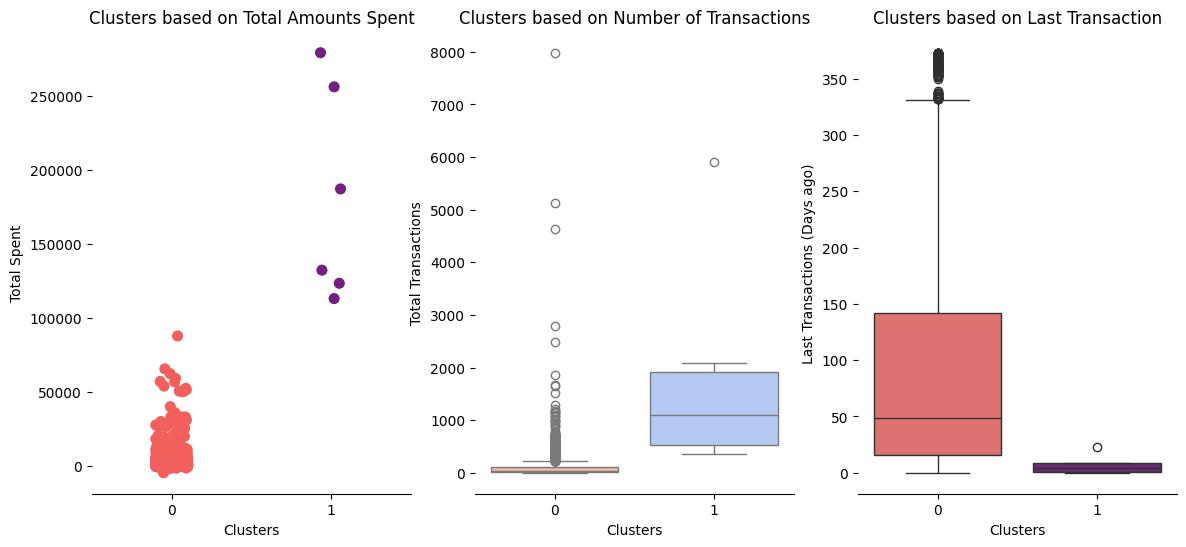

In [ ]:


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))
# Create a figure and a set of subplots.
# nrows=1, ncols=3: 1 row and 3 columns of subplots.
# figsize=(14, 6): Width and height of the figure in inches.

# Stripplot for Total Amount Spent
ty = sns.stripplot(
    x='pred', # Cluster assignments (x-axis)
    y='Total Amount Spent', # Total amount spent (y-axis)
    data=df_new, # DataFrame containing the data
    s=8, # Size of the points
    ax=ax[0], # Subplot to draw on (first subplot)
    hue='pred', # Color points by cluster assignment
    palette='magma_r', # Color palette to use
    legend=False # Don't display a legend
)
sns.despine(left=True) # Remove the left spine of the plot
ty.set_title('Clusters based on Total Amounts Spent') # Set the title of the subplot
ty.set_ylabel('Total Spent') # Set the y-axis label
ty.set_xlabel('Clusters') # Set the x-axis label

# Boxplot for Number of Transactions
tt = sns.boxplot(
    x='pred', # Cluster assignments (x-axis)
    y='InvoiceNo', # Number of transactions (y-axis)
    data=df_new, # DataFrame containing the data
    ax=ax[1], # Subplot to draw on (second subplot)
    hue='pred', # Color boxes by cluster assignment
    palette='coolwarm_r', # Color palette to use
    legend=False # Don't display a legend
)
tt.set_title('Clusters based on Number of Transactions') # Set the title of the subplot
tt.set_ylabel('Total Transactions') # Set the y-axis label
tt.set_xlabel('Clusters') # Set the x-axis label

# Boxplot for Last Transaction
tr = sns.boxplot(
    x='pred', # Cluster assignments (x-axis)
    y='Last_transact', # Last transaction (y-axis)
    data=df_new, # DataFrame containing the data
    ax=ax[2], # Subplot to draw on (third subplot)
    hue='pred', # Color boxes by cluster assignment
    palette='magma_r', # Color palette to use
    legend=False # Don't display a legend
)
tr.set_title('Clusters based on Last Transaction') # Set the title of the subplot
tr.set_ylabel('Last Transactions (Days ago)') # Set the y-axis label
tr.set_xlabel('Clusters') # Set the x-axis label

plt.show() # Display the plot

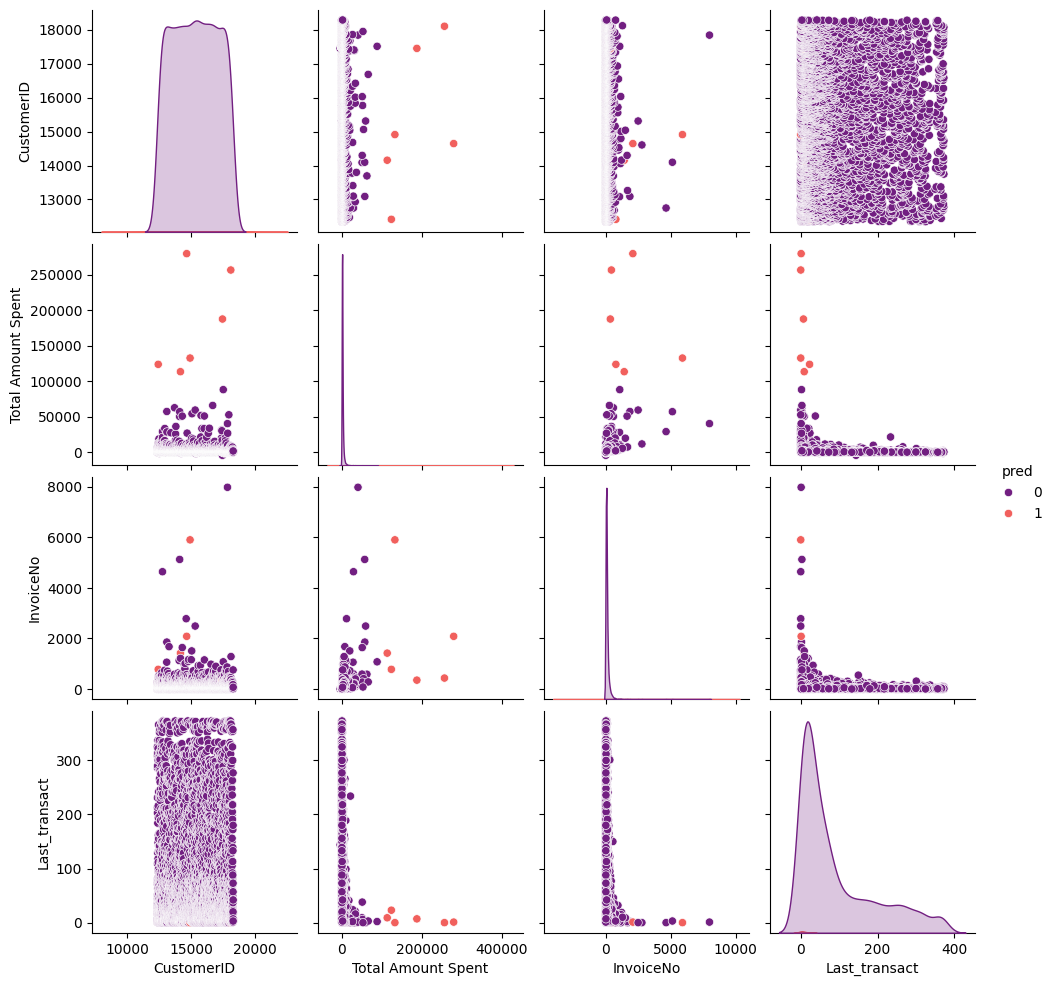

In [ ]:
#Visualize clusters using pairplot to display how the data in dataset relate to one another
sns.pairplot(hue='pred', data=df_new, diag_kind='kde', palette='magma')

# Elbow Method to decide how many Clusters to chose!
*  It is difficult to predict the right number of clusters that we should opt for
*  We can do this Elbow method to get the right number of clusters
*  After performing this we might add or reduce the number of clusters based on how much error we are reducing by increasing the clusters!


In [ ]:
kmeans.inertia_

100276002377.65228

In [ ]:
# Determine optimal number of clusters using the elbow method
error_rate = []
for clusters in range(1,16):
    kmeans = KMeans(n_clusters = clusters)
    kmeans.fit(df_new)
    kmeans.predict(df_new)
    error_rate.append(kmeans.inertia_)


In [ ]:
error_rate = pd.DataFrame({'Cluster':range(1,16) , 'Error':error_rate})

In [ ]:
error_rate

,Cluster,Error
0,1,3.085422e+11
1,2,1.132431e+11
2,3,6.277240e+10
3,4,4.337987e+10
4,5,3.110965e+10
5,6,2.197995e+10
6,7,1.768829e+10
7,8,1.435359e+10
8,9,1.198481e+10
9,10,8.803627e+09


Text(0.5, 1.0, 'Error Rate and Clusters')

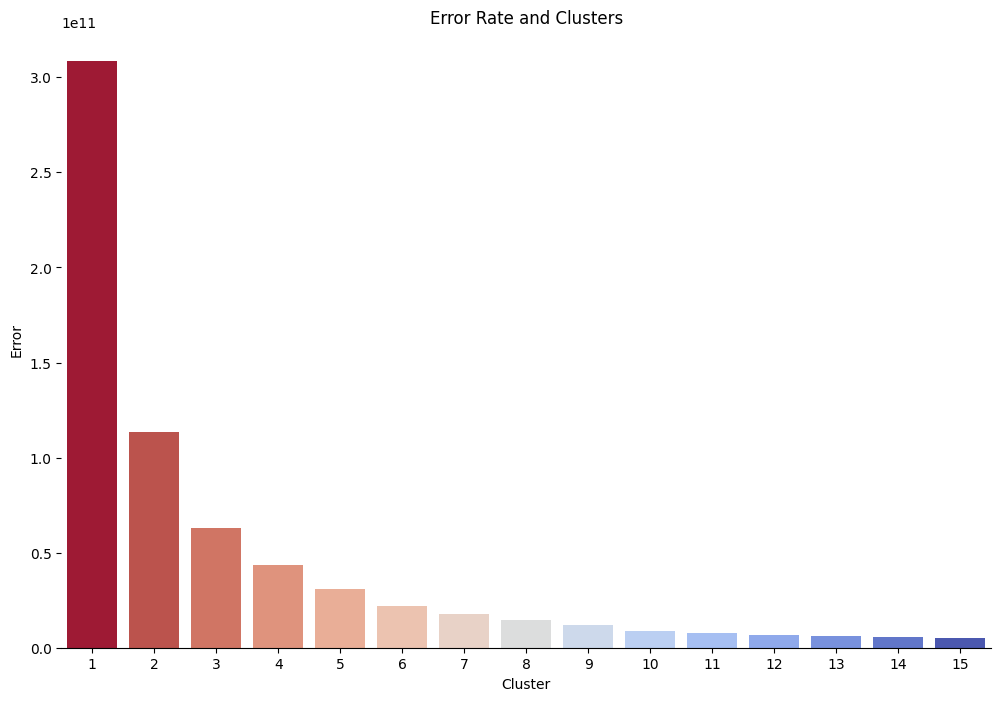

In [ ]:
plt.figure(figsize=(12,8))
p = sns.barplot(x='Cluster', y= 'Error', data= error_rate, hue='Cluster', palette='coolwarm_r', legend=False)
sns.despine(left=True)
p.set_title('Error Rate and Clusters')


# Analyze Cluster Characteristics (mean, median, standard deviation)

In [ ]:
# Assuming 'df_new' has the cluster assignments ('pred' column)

# Group by cluster and calculate statistics
cluster_stats = df_new.groupby('pred').agg({
    'Total Amount Spent': ['mean', 'median', 'std'],
    'InvoiceNo': ['mean', 'median', 'std'],
    'Last_transact': ['mean', 'median', 'std']
})

print(cluster_stats)

     Total Amount Spent                              InvoiceNo          \
                   mean      median           std         mean  median   
pred                                                                     
0           1650.704060     646.800   4128.279659    90.668575    42.0   
1         182181.981667  160027.395  71585.164123  1828.333333  1099.0   

                  Last_transact                     
              std          mean median         std  
pred                                                
0      211.935910     91.163078   49.0  100.785610  
1     2100.866075      6.666667    4.0    8.869423  


# Forecasting Spending with ARIMA

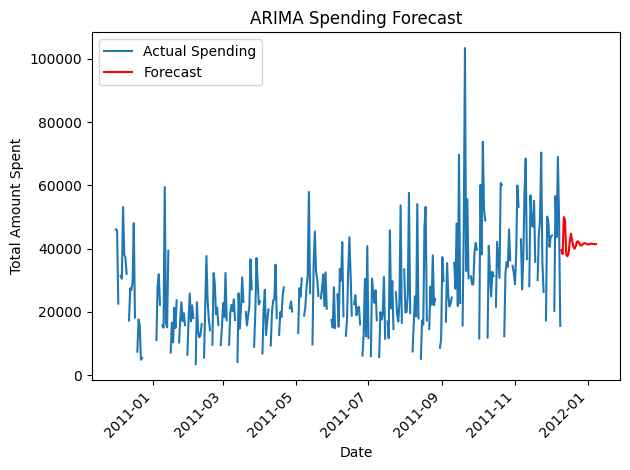

In [ ]:

# 1. Create spending_ts DataFrame
spending_ts = df[['InvoiceDate', 'Total Amount Spent']].copy()
spending_ts['InvoiceDate'] = pd.to_datetime(spending_ts['InvoiceDate']).dt.date
spending_ts = spending_ts.groupby('InvoiceDate')['Total Amount Spent'].sum().reset_index()
spending_ts = spending_ts.set_index('InvoiceDate')

#Infer the frequency
spending_ts = spending_ts.asfreq(pd.infer_freq(spending_ts.index))


# 2. Fit the ARIMA model
model = ARIMA(spending_ts['Total Amount Spent'], order=(5, 1, 0))
model_fit = model.fit()

# 3. Forecast Spending
forecast = model_fit.predict(start=len(spending_ts), end=len(spending_ts) + 29)


# 4. Plot the Forecast
plt.plot(spending_ts['Total Amount Spent'], label='Actual Spending')
plt.plot(forecast, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Spending Forecast')
plt.xlabel('Date')
plt.ylabel('Total Amount Spent')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()